In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle as pkl
import tensorflow as tf
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
def model_inputs(real_dim, z_dim):
    """create placeholder for data
        >>> model_inputs(1, 1)

     (real_dim, z_dim): (真のデータの次元, ノイズの次元)
    """
    inputs_real = tf.placeholder(tf.float32, (None, real_dim), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")

    return inputs_real, inputs_z

In [3]:
def generator(z, out_dim, n_unit=128, reuse=False, alpha=0.01):
    """generate fake data using multi-NN
        >>> generator(z, 784, 128)

    n_unit: 中間層のニューロンの数
    Leaky ReLU: x < 0でゼロにしない
    reuseオプション: 関数内の変数値の保持
    """
    with tf.variable_scope('generator', reuse=reuse):
        # fully-connected
        h1 = tf.layers.dense(z, n_unit, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        # score, fully-connected
        logits = tf.layers.dense(h1, out_dim, activation=None)
        # [-1, 1]: 画像
        out = tf.tanh(logits)

        return out

In [4]:
def discriminator(x, n_unit=128, reuse=False, alpha=0.01):
    """discriminator using multi-NN
        >>> discriminator(z, 784, 128, )
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        # fully-connected
        h1 = tf.layers.dense(x, n_unit, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        # score, fully-connected
        logits = tf.layers.dense(h1, 1, activation=None)
        # [0, 1]: 確率
        out = tf.sigmoid(logits)

        return out, logits

In [5]:
# MNIST_dataディレクトリにMNISTデータセットをダウンロードする
mnist = input_data.read_data_sets("MNIST_data")

"""ハイパーパラメータ"""
input_size = 784  # 入力画像サイズ 28 * 28
z_size = 100  # ランダムなベクトルサイズ
g_hidden_size = 128  # 隠れ層のノード数
d_hidden_size = 128  # 隠れ層のノード数
alpha = 0.01  # Leaky RELUの平滑度
smooth = 0.1  # 学習を円滑に進めるための値

"""モデルの定義"""
# グラフの初期化
tf.reset_default_graph()

# 入力データ定義
input_real, input_z = model_inputs(input_size, z_size)

# fake dataの作成
g_model = generator(input_z, input_size, n_unit=g_hidden_size, alpha=alpha)

# real dataの識別結果
d_model_real, d_logits_real = discriminator(
    input_real, n_unit=d_hidden_size, alpha=alpha
)
# fake dataの識別結果
d_model_fake, d_logits_fake = discriminator(
    g_model, reuse=True, n_unit=d_hidden_size, alpha=alpha
)


"""損失関数の定義"""
# 1 - smoothとの誤差, realをrealと見抜く
d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)
    )
)
# 0との誤差, fakeをfakeと見抜く
d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_logits_real)
    )
)

# discriminator loss
d_loss = d_loss_real + d_loss_fake

# 正解1との誤差, fakeをrealに近づけられたか
g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)
    )
)

"""最適化"""
learning_rate = 0.002

# weight, biasなどのパラメータをまとめて取り出す関数
t_vars = tf.trainable_variables()
# 分割
g_vars = [var for var in t_vars if var.name.startswith("generator")]
d_vars = [var for var in t_vars if var.name.startswith("discriminator")]

d_train_optimize = tf.train.AdamOptimizer(learning_rate).minimize(
    d_loss, var_list=d_vars
)
g_train_optimize = tf.train.AdamOptimizer(learning_rate).minimize(
    g_loss, var_list=g_vars
)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
"""計算グラフの実行"""
batch_size = 100
epoch = 100
samples = []  # fakeデータの保存
losses = []  # loss per epoch

# 学習ログ保存 -> generatorを使って画像の保存
saver = tf.train.Saver(var_list=g_vars)

# session開始
with tf.Session() as sess:
    # 変数の初期化
    sess.run(tf.global_variables_initializer())
    # エポックを回す
    for e in range(epoch):
        # 1epochで学習標本全てを用いる
        for i in range(mnist.train.num_examples // batch_size):
            # 無作為抽出
            batch = mnist.train.next_batch(batch_size)
            # 784次元のベクトルに変換する
            batch_images = batch[0].reshape((batch_size, 784))
            # generatorのデータとrangeを揃える [-1, 1]
            batch_images = batch_images * 2 - 1

            # Generatorにおけるfake画像生成, 一様分布
            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

            # discriminatorの最適化
            _ = sess.run(
                d_train_optimize, feed_dict={input_real: batch_images, input_z: batch_z}
            )
            # generatorの最適化
            _ = sess.run(g_train_optimize, feed_dict={input_z: batch_z})

        # loss
        train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
        train_loss_g = g_loss.eval({input_z: batch_z})
        print(
            "エポック: {}/{}".format(e + 1, epoch),
            "D_loss: {:.4f}".format(train_loss_d),
            "G_loss: {:.4f}".format(train_loss_g),
        )

        # loss追加
        losses.append((train_loss_d, train_loss_g))

        """fake画像の作成"""
        sample_z = np.random.uniform(-1, 1, size=(16, z_size))
        gen_samples = sess.run(
            generator(
                input_z, input_size, n_unit=g_hidden_size, reuse=True, alpha=alpha
            ),
            feed_dict={input_z: sample_z},
        )
        samples.append(gen_samples)
        # モデル保存
        saver.save(sess, "./checkpoints/generator.ckpt")

# samplesのsave
with open("./train_samples.pkl", "wb") as f:
    pkl.dump(samples, f)

エポック: 1/100 D_loss: 0.3724 G_loss: 3.5853
エポック: 2/100 D_loss: 0.6535 G_loss: 2.8369
エポック: 3/100 D_loss: 0.6676 G_loss: 7.6939
エポック: 4/100 D_loss: 2.1798 G_loss: 2.3512
エポック: 5/100 D_loss: 1.2005 G_loss: 3.0722
エポック: 6/100 D_loss: 0.6475 G_loss: 2.5068
エポック: 7/100 D_loss: 0.9326 G_loss: 1.3853
エポック: 8/100 D_loss: 0.8976 G_loss: 2.1406
エポック: 9/100 D_loss: 0.7073 G_loss: 2.5683
エポック: 10/100 D_loss: 1.0146 G_loss: 7.1544
エポック: 11/100 D_loss: 2.2505 G_loss: 1.5782
エポック: 12/100 D_loss: 2.3318 G_loss: 1.5906
エポック: 13/100 D_loss: 1.0315 G_loss: 1.8420
エポック: 14/100 D_loss: 1.4161 G_loss: 1.5715
エポック: 15/100 D_loss: 0.8199 G_loss: 2.4837
エポック: 16/100 D_loss: 1.6974 G_loss: 1.4839
エポック: 17/100 D_loss: 0.9610 G_loss: 2.0063
エポック: 18/100 D_loss: 1.3308 G_loss: 1.9380
エポック: 19/100 D_loss: 0.8335 G_loss: 2.0981
エポック: 20/100 D_loss: 1.1202 G_loss: 2.2264
エポック: 21/100 D_loss: 0.8593 G_loss: 1.7687
エポック: 22/100 D_loss: 1.2257 G_loss: 1.2910
エポック: 23/100 D_loss: 1.1750 G_loss: 1.3722
エポック: 24/100 D_loss:

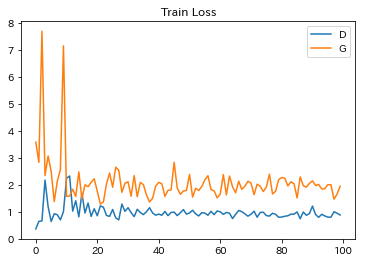

In [7]:
# ロスの表示
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='D')
plt.plot(losses.T[1], label='G')
plt.title('Train Loss')
plt.legend()

In [8]:
# イメージに変換して表示する
def view_samples(epoch, samples):
    # 画像と軸を描画する, 7*7, 4行4列, xy軸の表示
    fig, axes = plt.subplots(
        figsize=(7, 7), nrows=4, ncols=4, sharey=True, sharex=True, facecolor="w"
    )
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        # 28*28のグレースケールで表示させる
        im = ax.imshow(img.reshape((28, 28)), cmap="Greys_r")
    # 表示領域全体と軸や自由配置オブジェクト
    return fig, axes

In [9]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

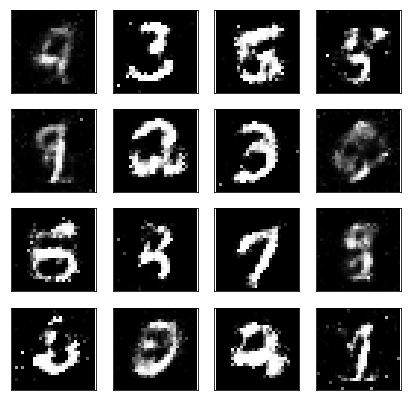

In [10]:
_ = view_samples(-1, samples)

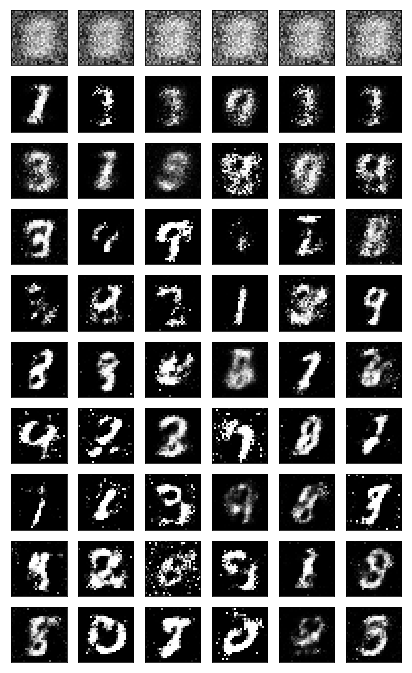

In [11]:
"""10回毎のfake dataを可視化する"""
# 行数と列数の設定
rows, cols = 10, 6
# グラフ全体と個別指定表示要素
fig, axes = plt.subplots(
    figsize=(7, 12), nrows=rows, ncols=cols, sharex=True, sharey=True, facecolor='w'
)

# サンプル数/10 毎にサンプルを取り出す
for sample, ax_row in zip(samples[:: int(len(samples) / rows)], axes):
    # 100/6 = 15 毎にサンプルを取り出す
    for img, ax in zip(sample[:: int(len(sample) / cols)], ax_row):
        # 784次元を28*28に変換
        ax.imshow(img.reshape((28, 28)), cmap="Greys_r")
        # x軸とy軸を非表示
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

INFO:tensorflow:Restoring parameters from checkpoints/generator.ckpt


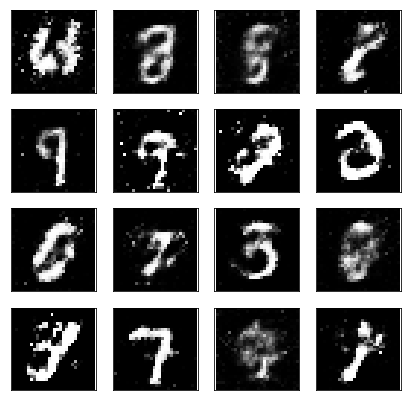

In [12]:
"""checkpointsから画像生成"""
# sessionを復元する
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    # checkpointsのフォルダ内にある最新のckptを取ってくる
    saver.restore(sess, tf.train.latest_checkpoint("checkpoints"))
    # ランダムノイズの生成
    sample_z = np.random.uniform(-1, 1, size=(16, z_size))
    # fake dataの生成
    gen_samples = sess.run(
        generator(input_z, input_size, n_unit=g_hidden_size, reuse=True, alpha=alpha),
        feed_dict={input_z: sample_z},
    )
    
_ = view_samples(0, [gen_samples])

In [13]:
losses

array([[0.3723752 , 3.5852823 ],
       [0.65345246, 2.8369088 ],
       [0.6676417 , 7.6939106 ],
       [2.179785  , 2.35119   ],
       [1.2004999 , 3.072151  ],
       [0.6475052 , 2.5068438 ],
       [0.9325907 , 1.3853415 ],
       [0.89758563, 2.1405761 ],
       [0.70730484, 2.5682511 ],
       [1.0145916 , 7.154434  ],
       [2.2505164 , 1.5781757 ],
       [2.3317552 , 1.590614  ],
       [1.0315347 , 1.8419837 ],
       [1.4160635 , 1.5714971 ],
       [0.8199045 , 2.4836967 ],
       [1.6973898 , 1.4838763 ],
       [0.9609992 , 2.006255  ],
       [1.3308063 , 1.9380441 ],
       [0.83351994, 2.098112  ],
       [1.1201978 , 2.226403  ],
       [0.85928434, 1.7686539 ],
       [1.2257199 , 1.2909595 ],
       [1.1750388 , 1.3721585 ],
       [0.87000203, 2.0446308 ],
       [0.83737856, 2.4412942 ],
       [1.092339  , 1.9126359 ],
       [0.7811379 , 2.6604297 ],
       [0.7084711 , 2.546444  ],
       [1.29405   , 1.7294359 ],
       [1.0221949 , 2.0640295 ],
       [1.